<a href="https://colab.research.google.com/github/HishamAhmed2/Neural-Data-Analysis/blob/main/fMRI_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data**: https://osf.io/j2wsc/wiki/home/

**publication**: Kay, K., Jamison, K.W., Zhang, RY. et al. A temporal decomposition method for identifying venous effects in task-based fMRI. Nat Methods 17, 1033–1039 (2020). https://doi.org/10.1038/s41592-020-0941-6

**Visualize flatmaps**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import scipy.io
mat = scipy.io.loadmat('/content/gdrive/MyDrive/Neural Data Analysis/exampledataset.mat')

Text(0.5, 1.0, 'standard deviation map')

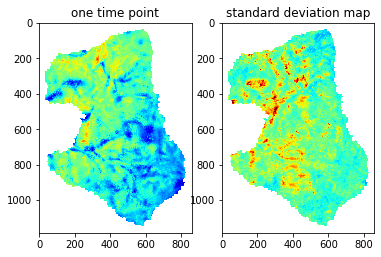

In [ ]:
from matplotlib import colorbar
import matplotlib.pyplot as plt
import numpy as np
data = mat['data']
numvoxels = data[0,0][:,0].size
onetimepoint = data[0,0][:,49]
onetimepoint = onetimepoint[mat['imglookup']]
onetimepoint[mat['extrapmask'] == True] = np.nan
plt.subplot(121)
plt.imshow(onetimepoint, cmap='jet') #spatial map at one time-point
plt.title('one time point')

stdmap = np.std(data[0,0], axis=1)
stdmap = stdmap[mat['imglookup']]
stdmap[mat['extrapmask'] == True] = np.nan
plt.subplot(122)
plt.imshow(stdmap, cmap='jet') #standard deviation map
plt.clim(0,200)
plt.title('standard deviation map')


**Preprocess BOLD signal data**

Text(0.5, 1.0, 'BOLD time course from voxel 12120')

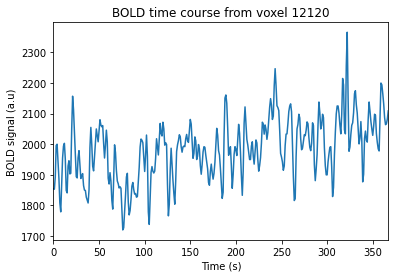

In [ ]:
#time courses of a random voxel
voxel2plot = 12120
time = (range(data[0,0][0,:].size)) / (1/mat['tr'][0][0]) #time vector converted from TRs to seconds
plt.plot(time, data[0,0][voxel2plot,:])
plt.xlim(0,time[-1])
plt.xlabel('Time (s)')
plt.ylabel('BOLD signal (a.u)')
plt.title('BOLD time course from voxel ' + str(voxel2plot))

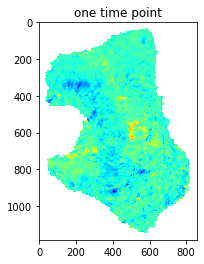

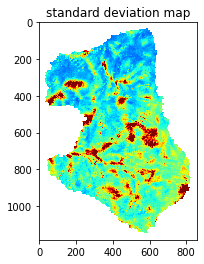

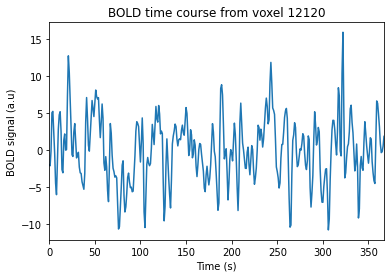

In [ ]:
# be careful while runing this cell of code as the main data is replaced
import scipy.signal
from matplotlib.pyplot import figure
#convert to percent change and detrend
for runi in range(data[0,:].size):
  meanvals = np.expand_dims(np.mean(data[0,runi], axis=1), axis=1)
  data[0,runi] = 100 * (data[0,runi] - meanvals)/meanvals
  data[0,runi] = scipy.signal.detrend(data[0,runi],axis = 1 )

numvoxels = data[0,0][:,0].size
onetimepoint = data[0,0][:,49]
onetimepoint = onetimepoint[mat['imglookup']]
onetimepoint[mat['extrapmask'] == True] = np.nan
plt.imshow(onetimepoint, cmap='jet')
plt.title('one time point')
plt.show()

stdmap = np.std(data[0,0], axis=1)
stdmap = stdmap[mat['imglookup']]
stdmap[mat['extrapmask'] == True] = np.nan
plt.imshow(stdmap, cmap='jet')
plt.clim(0,15)
plt.title('standard deviation map')
plt.show()

voxel2plot = 12120
time = (range(data[0,0][0,:].size)) / (1/mat['tr'][0][0])
plt.plot(time, data[0,0][voxel2plot,:])
plt.xlim(0,time[-1])
plt.xlabel('Time (s)')
plt.ylabel('BOLD signal (a.u)')
plt.title('BOLD time course from voxel ' + str(voxel2plot))
plt.show()

**Trial-averaged BOLD matrix**

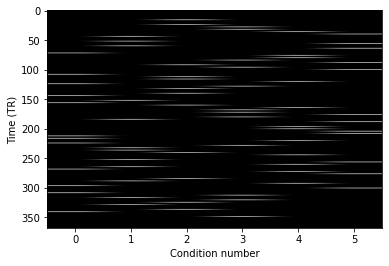

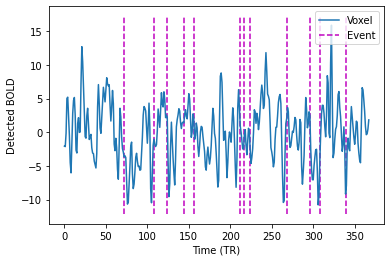

In [ ]:
import scipy.sparse
from matplotlib.pyplot import figure
design1strun = scipy.sparse.csr_matrix.toarray(mat['design'][0,0])
plt.imshow(design1strun, cmap='gray', aspect='auto') #design matrix as lines
plt.ylabel('Time (TR)')
plt.xlabel('Condition number')
plt.show()

plt.plot(data[0,0][voxel2plot,:])
xmin, xmax, ymin, ymax = plt.axis()
eventonsets = np.where(design1strun[:,0]==1)
for ei in eventonsets:
   plt.vlines(ei, ymin, ymax, color='m',linestyle='dashed' ) #events plotted on top of the time course
plt.xlabel('Time (TR)')
plt.ylabel('Detected BOLD')
plt.legend(['Voxel', 'Event'],loc='upper right')
plt.show()

Text(0, 0.5, 'Voxel index')

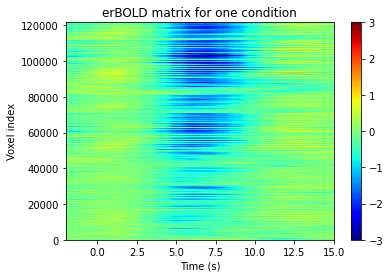

In [ ]:
timebounds = [-2,15]
timevec = np.arange(timebounds[0], timebounds[1]+1) / (1/mat['tr'][0][0])
erBOLD = np.zeros((6,numvoxels,len(timevec)))
for condi in range(6): #loop over condition
  for runi in range(4): #loop over runs
    events = np.where(scipy.sparse.csr_matrix.toarray(mat['design'][0,runi])[:,condi] ==1) #all events of this condition in this run
    tmp = np.zeros((numvoxels,len(timevec)))
    for ei in events[0]:  
      tmp = tmp + data[0,runi][:, ei+timebounds[0] : ei+timebounds[1]+1] #peri-event time series in a temporary variable
    erBOLD[condi,:,:] = erBOLD[condi,:,:] + tmp/events[0].size
erBOLD = erBOLD/(runi+1) #divide for mean
plt.imshow(erBOLD[0,:,:], cmap='jet', aspect='auto', extent=[timevec[0],timevec[-1],0, numvoxels])
plt.clim(-3,3)
plt.colorbar()
plt.title('erBOLD matrix for one condition')
plt.xlabel('Time (s)')
plt.ylabel('Voxel index')


**Animation of BOLD responses over time**

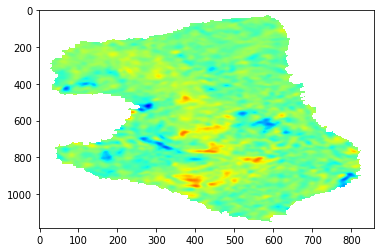

In [ ]:
from IPython.core.pylabtools import figsize
from time import sleep
import scipy.signal
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
from matplotlib.animation import PillowWriter

#gaussian for the spatial smoothing
Y,X = np.meshgrid(np.linspace(-4,4,21),np.linspace(-4,4,21))
G= np.exp( -(X**2 + Y**2)/10 )
G = G / np.sum(G)
fig, ax = plt.subplots()
ax= plt.imshow(np.random.randn(mat['imglookup'].shape[0], mat['imglookup'].shape[1]), aspect='auto', cmap='jet',animated=True) #setup the figure

condition = 5
def animation(i): # animation function
  timepointmap = erBOLD[condition,:, i]
  timepointmap = timepointmap[mat['imglookup']]
  timepointmap = scipy.signal.convolve2d(timepointmap, G, 'same')
  timepointmap[mat['extrapmask'] == True] = np.nan      
  ax.set_array(timepointmap)

ani = FuncAnimation(plt.gcf(), animation,frames = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],interval=500)
ani.save("animation.gif", dpi=300,
         writer=PillowWriter(fps=1))
# todo: all conditions need to be shown in same figure

**Event-related BOLD time courses**

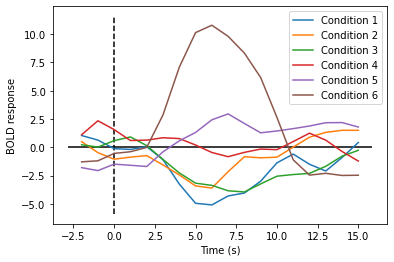

In [ ]:
# visualizing one voxel in all conditions allover timevec
dataidx = mat['imglookup'][463,465]
for i in range(erBOLD.shape[0]):
  plt.plot(timevec, erBOLD[i,dataidx,:])
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(0, ymin, ymax, color='k',linestyle='dashed' )
plt.hlines(0, xmin,xmax, color='k') 
plt.xlabel('Time (s)')
plt.ylabel('BOLD response')
plt.legend(['Condition 1', 'Condition 2', 'Condition 3', 'Condition 4', 'Condition 5', 'Condition 6'],loc='upper right') 

**T-test on condition differences**

Text(0.5, 1.0, 'T-test on condition 1 vs 6')

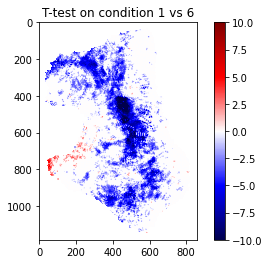

In [ ]:
from scipy import stats
map1 =np.zeros((121695,1))
map6 = np.zeros((121695,1))
#simple t-test at 6s after two events
for runi in range(4):
  events1= np.where(scipy.sparse.csr_matrix.toarray(mat['design'][0,runi])[:,0]==1) #all occurances of events 1 and 6
  events6= np.where(scipy.sparse.csr_matrix.toarray(mat['design'][0,runi])[:,5]==1) 
  map1 = np.concatenate((map1, data[0,runi][:,events1[0]+6]), axis=1)
  map6 = np.concatenate((map6, data[0,runi][:,events6[0]+6]),axis=1)


t, p = scipy.stats.ttest_rel(map1.T,map6.T) #paired T-test
t[p>0.01] = 0
tmapbrain = t[mat['imglookup']]
tmapbrain[mat['extrapmask'] == True] = np.nan  
plt.imshow(tmapbrain, cmap='seismic')
plt.clim(-10,10)
plt.colorbar()
plt.title('T-test on condition 1 vs 6')